In [66]:
!pip install transformers

In [67]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [68]:
!pip install ktrain

In [69]:
import ktrain
from ktrain import text

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/en_Hasoc2021_train.csv')

df.head(10)

Unnamed: 0                       _id  ... task_1 task_2
0        4986  60c5d6bf5659ea5e55defa2c  ...    HOF   PRFN
1        3394  60c5d6bf5659ea5e55def461  ...    HOF   OFFN
2        1310  60c5d6bf5659ea5e55defaad  ...    NOT   NONE
3        3390  60c5d6bf5659ea5e55def419  ...    HOF   OFFN
4        4626  60c5d6bf5659ea5e55def7fa  ...    HOF   OFFN
5        1506  60c5d6bf5659ea5e55defc58  ...    HOF   PRFN
6        2298  60c5d6bf5659ea5e55df0132  ...    NOT   NONE
7         309  60c5d6bf5659ea5e55def378  ...    NOT   NONE
8        3582  60c5d6bf5659ea5e55def54f  ...    HOF   HATE
9        2139  60c5d6bf5659ea5e55df0086  ...    NOT   NONE

[10 rows x 5 columns]

In [72]:
df = df.drop("Unnamed: 0", axis=1)
df = df.drop("_id", axis=1)
df = df.drop("task_2", axis=1)

df.head(10)

text task_1
0  @wealth if you made it through this &amp;&amp;...    HOF
1  Technically that's still turning back the cloc...    HOF
2  @VMBJP @BJP4Bengal @BJP4India @narendramodi @J...    NOT
3  @krtoprak_yigit Soldier of Japan Who has dick ...    HOF
4  @blueheartedly You'd be better off asking who ...    HOF
5                                   @ilyhiguchi DICK    HOF
6  Why to blame only Modi or Government for this ...    NOT
7  The report on @TheLeadCNN that @clarissaward f...    NOT
8  @Chahal_Shekhar Sorry we won't, why can't your...    HOF
9  People are dying even in villages where there'...    NOT

In [73]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

df = df[["task_1", "text"]]
x = np.array(df["text"])
y = np.array(df["task_1"])

cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
clf = MultinomialNB()
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)

# Classification Report
from sklearn.metrics import classification_report
#print(classification_report(y_test, predictions))

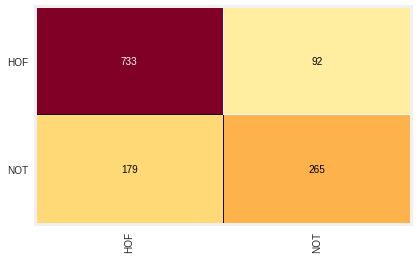

In [74]:
import matplotlib.pyplot as plt

from yellowbrick.classifier import ConfusionMatrix

from sklearn.linear_model import LogisticRegression

viz = ConfusionMatrix(LogisticRegression())

viz.fit(X_train, y_train)

viz.score(X_test, y_test)

plt.show()

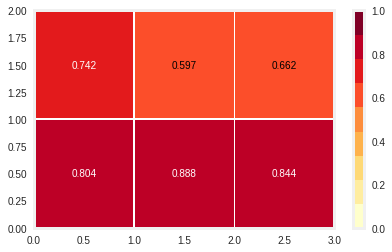

In [75]:
import matplotlib.pyplot as plt

from yellowbrick.classifier import ClassificationReport

from sklearn.linear_model import LogisticRegression

viz = ClassificationReport(LogisticRegression())

viz.fit(X_train, y_train)

viz.score(X_test, y_test)

plt.show()

In [76]:
list(df.columns.values)

['task_1', 'text']

In [77]:
df = df[['text', 'task_1']] 
df['task_1'] = df['task_1'].apply(lambda x: 'neg' if x == "HOF" else 'pos')
df.columns = ['text', 'label']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'neg', 'pos']]

df.head(10)

text  neg  pos
0  @wealth if you made it through this &amp;&amp;...    1    0
1  Technically that's still turning back the cloc...    1    0
2  @VMBJP @BJP4Bengal @BJP4India @narendramodi @J...    0    1
3  @krtoprak_yigit Soldier of Japan Who has dick ...    1    0
4  @blueheartedly You'd be better off asking who ...    1    0
5                                   @ilyhiguchi DICK    1    0
6  Why to blame only Modi or Government for this ...    0    1
7  The report on @TheLeadCNN that @clarissaward f...    0    1
8  @Chahal_Shekhar Sorry we won't, why can't your...    1    0
9  People are dying even in villages where there'...    0    1

In [78]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 
                                                                   'text', # name of column containing review text
                                                                   label_columns=['neg', 'pos'],
                                                                   maxlen=75, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.1,
                                                                   ngram_range=3)

['neg', 'pos']
      neg  pos
2054    0    1
2649    0    1
1513    1    0
3553    1    0
625     1    0
['neg', 'pos']
      neg  pos
2829    1    0
902     0    1
2033    0    1
708     1    0
478     1    0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [79]:
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

history = x_train, y_train, x_test, y_test

Is Multi-Label? False
maxlen is 75
done.


In [80]:
#learner.lr_find(max_epochs=12)
#learner.lr_plot()

In [81]:
learner.fit(1e-06, 40)

Epoch 1/40
109/109 [==============================] - 135s 1s/step - loss: 0.6263 - accuracy: 0.6533 - val_loss: 0.5857 - val_accuracy: 0.6987
Epoch 2/40
109/109 [==============================] - 108s 990ms/step - loss: 0.5826 - accuracy: 0.7001 - val_loss: 0.5452 - val_accuracy: 0.7299
Epoch 3/40
109/109 [==============================] - 108s 991ms/step - loss: 0.5444 - accuracy: 0.7342 - val_loss: 0.5148 - val_accuracy: 0.7610
Epoch 4/40
109/109 [==============================] - 108s 990ms/step - loss: 0.5132 - accuracy: 0.7571 - val_loss: 0.4973 - val_accuracy: 0.7766
Epoch 5/40
109/109 [==============================] - 108s 990ms/step - loss: 0.4856 - accuracy: 0.7698 - val_loss: 0.4844 - val_accuracy: 0.7740
Epoch 6/40
109/109 [==============================] - 108s 991ms/step - loss: 0.4613 - accuracy: 0.7857 - val_loss: 0.4753 - val_accuracy: 0.7844
Epoch 7/40
109/109 [==============================] - 108s 991ms/step - loss: 0.4371 - accuracy: 0.8016 - val_loss: 0.4714 - va

In [82]:
import matplotlib.pyplot as plt 
import numpy as np

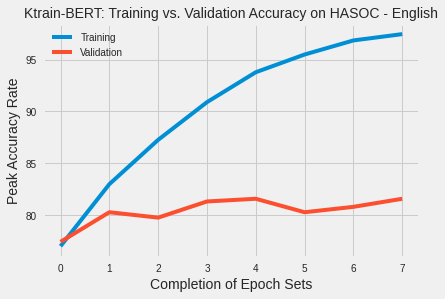

In [118]:
plt.style.use('fivethirtyeight')


rows, cols = 1, 1

plt.plot([76.98, 82.97, 87.25, 90.89, 93.78, 95.49, 96.85, 97.46], label='Training')
plt.plot([77.40, 80.26, 79.74, 81.30, 81.56, 80.26, 80.78, 81.56], label='Validation')
        
 
# Add labels and title
plt.title("Ktrain-BERT: Training vs. Validation Accuracy on HASOC - English", fontsize=14)
plt.xlabel("Completion of Epoch Sets", fontsize=14)
plt.ylabel("Peak Accuracy Rate", fontsize=14)
        
plt.legend()

In [84]:
learner.model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 75)]         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 75)]         0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 75, 768), (3 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 75, 768)      1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [85]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:139 | loss:7.77 | true:pos | pred:neg)

[CLS] @ na ##ren ##dra ##mo ##di @ ami ##ts ##ha ##h @ ra ##hul ##gan ##dhi @ r ##g ##way ##ana ##do ##ffi ##ce its been long time holding my words . this is the worst leader i have seen @ na ##ren ##dra ##mo ##di you are such ##na worthless leader . # resign ##mo ##di # na ##ren ##dra ##mo ##di # bullshit # hate ##rs # india ##lov ##er # [SEP]


In [86]:
p = ktrain.get_predictor(learner.model, preproc)

In [87]:
!pip install tensorflow
!pip install keras

import tensorflow as tf

import keras

!pip install eli5
!pip install lime

In [88]:
!pip install https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip

  Using cached https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip


In [89]:
statement = "The Razer Blade 15 is really good this year!"

In [90]:
p.explain(statement)

In [91]:
p.predict(statement)

'pos'

In [92]:
statement = "Any Daniel D. Lewis movie is almost flawless."

In [93]:
p.explain(statement)

In [94]:
statement = "Real Madrid has an excellent record in the Champions League"

In [95]:
p.explain(statement)

In [96]:
statement = "Ryzen is a winner, and you're a freak to think otherwise."

In [97]:
p.explain(statement)

In [98]:
p.predict(statement)

'neg'

In [99]:
statement = "Stop being a twat then"

In [100]:
p.explain(statement)

In [115]:
statement = "You are hopeless. Retire, wanker."

In [116]:
p.explain(statement)

In [103]:
df2 = pd.read_csv('/content/drive/MyDrive/en_Hasoc2021_test_task1.csv')

df2.head(10)

_id                                               text
0  60c5d6bf5659ea5e55deffcb  Fewer people coming in for vaccinations. So sa...
1  60c5d6bf5659ea5e55df028c  @MattHancock This may all be true. But... What...
2  60c5d6bf5659ea5e55def377          @Layla_EFC I’ve unfollowed him the wanker
3  60c5d6bf5659ea5e55def4c7  You guys are losing it all over the world. The...
4  60c5d6bf5659ea5e55df01a6  And thus death laughs... It is sad merriment, ...
5  60c5d6bf5659ea5e55def837  Oh shooooot. IPL has been suspended 😱  #Cricke...
6  60c5d6bf5659ea5e55def6ec            Fuck y’all lmao https://t.co/n9SX9ThxRv
7  60c5d6bf5659ea5e55def29e  @narendramodi you are the one to blame for the...
8  60c5d6bf5659ea5e55defa01  dont ask me to cook anything aside from poultr...
9  60c5d6bf5659ea5e55def464  "The world suffers a lot. Not because of the v...

In [104]:
import os
import csv
import pandas as pd
import numpy as np
#import nltk
#from nltk.corpus import stopwords
#from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [105]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [106]:
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

In [107]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [108]:
data = df2
data.head()

_id                                               text
0  60c5d6bf5659ea5e55deffcb  Fewer people coming in for vaccinations. So sa...
1  60c5d6bf5659ea5e55df028c  @MattHancock This may all be true. But... What...
2  60c5d6bf5659ea5e55def377          @Layla_EFC I’ve unfollowed him the wanker
3  60c5d6bf5659ea5e55def4c7  You guys are losing it all over the world. The...
4  60c5d6bf5659ea5e55df01a6  And thus death laughs... It is sad merriment, ...

In [109]:
data['text'] = data['text'].str.lower()
data['text'] = data['text'].apply(cleanHtml)
data['text'] = data['text'].apply(cleanPunc)
data['text'] = data['text'].apply(keepAlpha)
data.head()

_id                                               text
0  60c5d6bf5659ea5e55deffcb  fewer people coming in for vaccinations so sad...
1  60c5d6bf5659ea5e55df028c  matthancock this may all be true but what did ...
2  60c5d6bf5659ea5e55def377           layla efc i ve unfollowed him the wanker
3  60c5d6bf5659ea5e55def4c7  you guys are losing it all over the world the ...
4  60c5d6bf5659ea5e55df01a6  and thus death laughs it is sad merriment but ...

In [110]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)

(896, 2)
(385, 2)


In [111]:
train_text = train['text']
test_text = test['text']

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1, 1282), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(ngram_range=(1, 1282), strip_accents='unicode')

In [113]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['text'], axis=1)

In [114]:
print(train_text, x_train)

136     i think its time to stop blaming modi for all ...
310     geethak mp  twitterindia  geethak mp in  andhr...
1068    oh this extremely alarming chinesevirus biowar...
522     it is obscene to say that narendra modi is the...
875     seems they were shopping not attending a relig...
                              ...                        
1044    poynterton bloody hell jekyll and hydes been u...
1095    history has never seen such blatant denial and...
1130    when i see florida gov trending i can only ass...
860     cm ndgooner bloody hell did you get taught the...
1126    amemoott  ripple  uct news  qz  coinbase  cz b...
Name: text, Length: 896, dtype: object   (0, 158506)	0.1428887840595122
  (0, 154343)	0.1380160270260162
  (0, 142674)	0.16737772649166124
  (0, 139410)	0.050768808239604134
  (0, 139061)	0.1428887840595122
  (0, 138858)	0.11537099984838123
  (0, 136160)	0.16737772649166124
  (0, 136112)	0.13389616965667983
  (0, 135474)	0.1565411968343148
  (0, 135212)	0.0908